In [ ]:
import numpy as np
from numba import jit, cuda 
import os
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
import pickle 

from keras.optimizers import Adam
from keras.applications import resnet50
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
import pandas as pd
from skimage.segmentation import quickshift,felzenszwalb,slic
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from scipy import ndimage
from skimage.segmentation import mark_boundaries
import cv2
from skimage.measure import regionprops
import math
from skimage.filters import threshold_otsu
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
from PIL import Image
import tensorflow as tf


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16991788870237541147
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 4795720439095395188
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 14151404089863053078
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15695549568
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11799444288576182247
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


In [ ]:
import cv2
import os
folder='/content/drive/My Drive/Dissertation/Images/segmented/segmented_cc_sample2/segmented_cc_sample/'
@jit
def load_images_from_folder(folder):
    images = []
    label=[]
    count=0
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, dsize=(224,224), interpolation=cv2.INTER_CUBIC)
        label.append(filename)
       # print(count)
        if img is not None:
            images.append(np.array(img))
            print(count)
           # print(img.)
        count =count+1
    return images,label

In [ ]:
images,label=load_images_from_folder(folder)

<ipython-input-9-c55980fa42c4>:7: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "load_images_from_folder" failed type inference due to: Unknown attribute 'listdir' of type Module(<module 'os' from '/usr/lib/python3.6/os.py'>)

File "<ipython-input-9-c55980fa42c4>", line 12:
def load_images_from_folder(folder):
    <source elided>
    count=0
    for filename in os.listdir(folder):
    ^

[1] During: typing of get attribute at <ipython-input-9-c55980fa42c4> (12)

File "<ipython-input-9-c55980fa42c4>", line 12:
def load_images_from_folder(folder):
    <source elided>
    count=0
    for filename in os.listdir(folder):
    ^

  @jit
<ipython-input-9-c55980fa42c4>:7: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "load_images_from_folder" failed type inference due to: cannot determine Numba type of <class 'numba.dispatcher.LiftedLoop'>

File "<ipython-input-9-c55980fa42c4>", line 1

Streaming output truncated to the last 5000 lines.
16191
16192
16193
16194
16195
16196
16197
16198
16199
16200
16201
16202
16203
16204
16205
16206
16207
16208
16209
16210
16211
16212
16213
16214
16215
16216
16217
16218
16219
16220
16221
16222
16223
16224
16225
16226
16227
16228
16229
16230
16231
16232
16233
16234
16235
16236
16237
16238
16239
16240
16241
16242
16243
16244
16245
16246
16247
16248
16249
16250
16251
16252
16253
16254
16255
16256
16257
16258
16259
16260
16261
16262
16263
16264
16265
16266
16267
16268
16269
16270
16271
16272
16273
16274
16275
16276
16277
16278
16279
16280
16281
16282
16283
16284
16285
16286
16287
16288
16289
16290
16291
16292
16293
16294
16295
16296
16297
16298
16299
16300
16301
16302
16303
16304
16305
16306
16307
16308
16309
16310
16311
16312
16313
16314
16315
16316
16317
16318
16319
16320
16321
16322
16323
16324
16325
16326
16327
16328
16329
16330
16331
16332
16333
16334
16335
16336
16337
16338
16339
16340
16341
16342
16343
16344
16345
16346
16347
16348
1

In [ ]:
meta_data=pd.read_csv("/content/drive/My Drive/Dissertation/metadata.csv")

In [ ]:
data_tuples = list(zip(images,label))

In [ ]:
df_images_label=pd.DataFrame(data_tuples, columns=['Images','Label'])

In [ ]:
df_images_label.to_pickle('/content/drive/My Drive/Dissertation/Images/segmented/segments_sample2_50*50.pkl') 

In [ ]:
df_images_label1 = pd.read_pickle('/content/drive/My Drive/Dissertation/Images/segmented/segments_sample2_50*50.pkl')

In [ ]:
df_images_label1 = pd.read_pickle('/content/drive/My Drive/Dissertation/Images/segments_sample2.pkl')

In [ ]:
df_images_label1.shape

(21190, 2)

In [ ]:
df_images_label1['ImgID']=df_images_label1.apply(lambda x: x['Label'][:-10], axis = 1).values

In [ ]:
df_images_label1['PatientLabel']=df_images_label1.apply(lambda x: x['Label'][-5:-4], axis = 1).values

In [ ]:
df_merge_col_lat = df_images_label1

In [ ]:
#df_merge_col_lat.drop(df_merge_col_lat.index[df_merge_col_lat['PatientLabel'] == 'B'], inplace = True)

In [ ]:
df_merge_col_lat['PatientLabel'].value_counts()

N    10000
M     9674
Name: PatientLabel, dtype: int64

In [ ]:
df_merge_col_lat.head(2)

,Images,Label,ImgID,PatientLabel
0,"[[[255, 255, 255], [255, 255, 255], [171, 171,...",1.2.826.0.1.3680043.9.3218.1.1.1560877.6143.15...,1.2.826.0.1.3680043.9.3218.1.1.1560877.6143.15...,M
1,"[[[255, 255, 255], [255, 255, 255], [214, 214,...",1.2.826.0.1.3680043.9.3218.1.1.1560877.6143.15...,1.2.826.0.1.3680043.9.3218.1.1.1560877.6143.15...,M


In [ ]:
#di = {"M": 1, "CI": 1,"B": 0, "N": 0}
di = {"M": 1, "B": 0,"CI": 1, "N": 0}
df_merge_col_lat['PatientLabel_en']=df_merge_col_lat['PatientLabel'].map(di)

In [ ]:
df_merge_col_lat['PatientLabel_en'].value_counts()

0    10000
1     9674
Name: PatientLabel_en, dtype: int64

In [ ]:
#from sklearn.utils import resample
#df_majority = df_merge_col_lat[df_merge_col_lat.PatientLabel_en==0]
#df_minority = df_merge_col_lat[df_merge_col_lat.PatientLabel_en==1]
 
# Downsample majority class
#df_majority_downsampled = resample(df_majority, 
#                                 replace=False,    # sample without replacement
#                                 n_samples=1000,     # to match minority class
 #                                random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
#df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
#df_downsampled.PatientLabel_en.value_counts()

0    1000
1     485
Name: PatientLabel_en, dtype: int64

In [ ]:
X = np.array([i for i in df_merge_col_lat['Images']])
Y = [i for i in df_merge_col_lat['PatientLabel_en']]

In [ ]:
X1 = X.reshape((X.shape[0], 224, 224,3))


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train1, y_test1 = train_test_split(X1, Y, test_size=0.2, random_state=42)
X_train, X_cv, y_train1, y_cv1 = train_test_split(X_train, y_train1, test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape)
print(X_cv.shape)
print(X_test.shape)

(12591, 224, 224, 3)
(3148, 224, 224, 3)
(3935, 224, 224, 3)


In [ ]:
y_train = keras.utils.to_categorical(y_train1, 2)
y_test = keras.utils.to_categorical(y_test1, 2)
y_cv = keras.utils.to_categorical(y_cv1, 2)

RESNET50

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
base_model = keras.applications.resnet50.ResNet50(weights= None, include_top=False, input_shape= (50,50,3))

In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 50, 50, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 56, 56, 3)    0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 25, 25, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 25, 25, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
#x = Dropout(0.3)(x)
predictions = Dense(2, activation= 'softmax')(x)
model_1 = Model(inputs = base_model.input, outputs = predictions)

In [ ]:
from sklearn.metrics import roc_auc_score
def auc(y_true,y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

In [ ]:

from keras.optimizers import SGD
class_weight = {0: 1,
                1: 1.5}
opt = Adam(lr=0.00001)
optimizer=SGD(lr=0.0001, momentum=0.9)
model_1.compile(optimizer=opt, loss='categorical_crossentropy',metrics=[auc])

In [ ]:
#,class_weight=class_weight
history=model_1.fit(X_train, y_train, epochs = 50, batch_size = 108,validation_data=(X_cv,y_cv))

Train on 12591 samples, validate on 3148 samples
Epoch 1/50
12591/12591 [==============================] - 13s 1ms/sample - loss: 0.7431 - auc: 0.5499 - val_loss: 0.6895 - val_auc: 0.6019
Epoch 2/50
12591/12591 [==============================] - 11s 866us/sample - loss: 0.7088 - auc: 0.5863 - val_loss: 0.6805 - val_auc: 0.5943
Epoch 3/50
12591/12591 [==============================] - 11s 869us/sample - loss: 0.6839 - auc: 0.6218 - val_loss: 0.6794 - val_auc: 0.5992
Epoch 4/50
12591/12591 [==============================] - 11s 866us/sample - loss: 0.6724 - auc: 0.6436 - val_loss: 0.6727 - val_auc: 0.6129
Epoch 5/50
12591/12591 [==============================] - 11s 865us/sample - loss: 0.6605 - auc: 0.6546 - val_loss: 0.6723 - val_auc: 0.6349
Epoch 6/50
12591/12591 [==============================] - 11s 867us/sample - loss: 0.6532 - auc: 0.6639 - val_loss: 0.6700 - val_auc: 0.6451
Epoch 7/50
12591/12591 [==============================] - 11s 865us/sample - loss: 0.6424 - auc: 0.6817 - v

In [ ]:
#import numpy as np
import time
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
#, colors=['b']
def plt_dynamic(x, vy, ty, ax,colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()
    #plt.show()

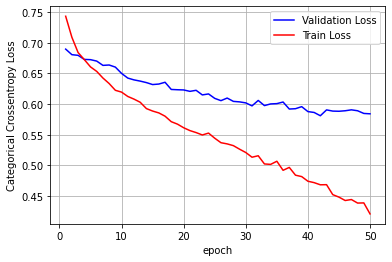

In [ ]:
#score = my_model.evaluate(X_test, y_test, verbose=0) 
#print('Test score:', score[0]) 
#print('Test accuracy:', score[1])
nb_epoch=50
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,nb_epoch+1))

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

In [ ]:
#results = model_1.evaluate(X_test, y_test)
#print("test loss, test auc:", results)

In [ ]:
from sklearn.metrics import roc_curve, auc
probs1 = model_1.predict(X_test)
probs = probs1[:, 1]
fpr1, tpr1, thresholds1 = roc_curve(y_test1, probs)
roc_auc = auc(fpr1, tpr1)

In [ ]:
roc_auc

0.7780406897888006

In [ ]:
from sklearn.metrics import confusion_matrix
y_pred=model_1.predict(X_test)
#y_classes = keras.np_utils.probas_to_classes(y_pred)
y_pred_class = np.argmax(y_pred, axis=1)
cm=confusion_matrix(y_test1,y_pred_class)
print(cm)

[[1453  532]
 [ 606 1344]]


In [ ]:
import pickle 
#pickle.dump(model_1,open('/content/drive/My Drive/Dissertation/Images/vgg16_cc_auc0_64.pkl','wb')) 
model_1.save('/content/drive/My Drive/Dissertation/Images/segmented_resnet50_auc0_80') 

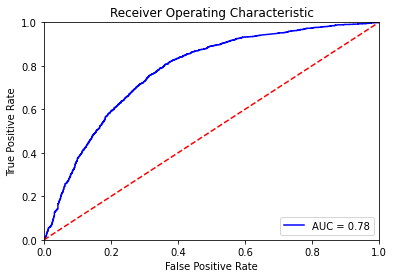

In [ ]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr1, tpr1, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# method II: ggplot
#from ggplot import *
##df = pd.DataFrame(dict(fpr = fpr, tpr = tpr))
#ggplot(df, aes(x = 'fpr', y = 'tpr')) + geom_line() + geom_abline(linetype = 'dashed')

In [ ]:
#import numpy as np
import time
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
#, colors=['b']
def plt_dynamic_auc(x, vy, ty, ax,colors=['b']):
    ax.plot(x, vy, 'b', label="Validation AUC")
    ax.plot(x, ty, 'r', label="Train AUC")
    plt.legend()
    plt.grid()
    fig.canvas.draw()
    #plt.show()

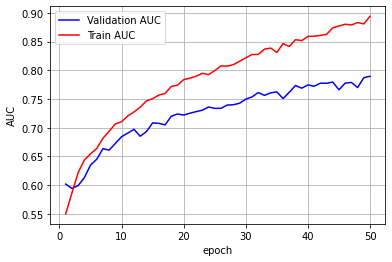

In [ ]:
#score = my_model.evaluate(X_test, y_test, verbose=0) 
#print('Test score:', score[0]) 
#print('Test accuracy:', score[1])
nb_epoch=50
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('AUC')

# list of epoch numbers
x = list(range(1,nb_epoch+1))

vy = history.history['val_auc']
ty = history.history['auc']
plt_dynamic_auc(x, vy, ty, ax)

-------------------- Confusion matrix --------------------


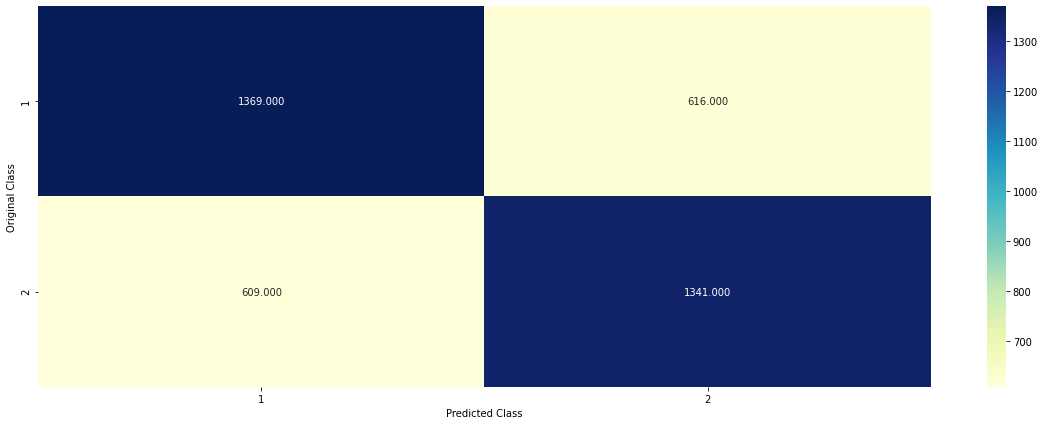

-------------------- Precision matrix (Columm Sum=1) --------------------


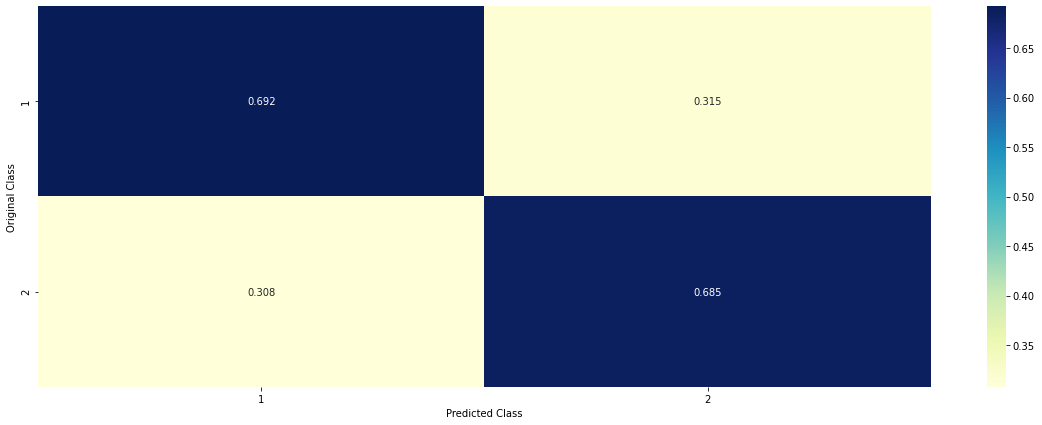

-------------------- Recall matrix (Row sum=1) --------------------


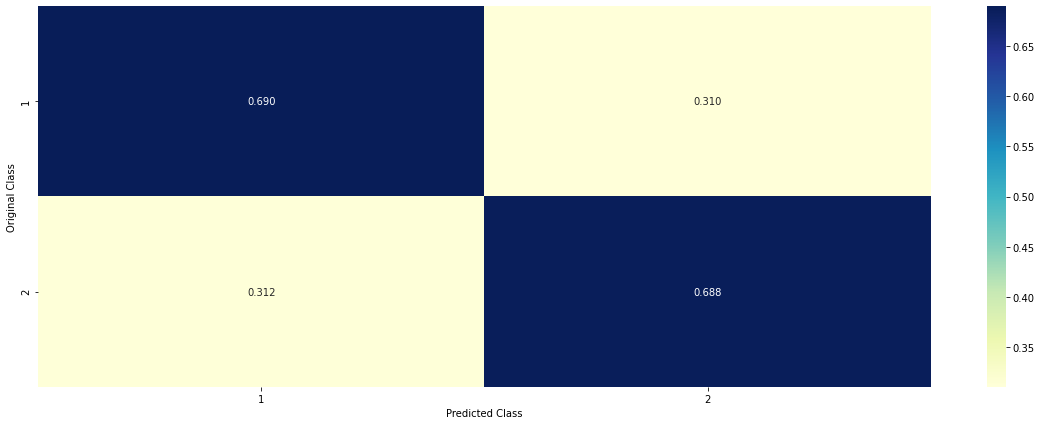

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
plot_confusion_matrix(y_test1,y_pred_class)

VGG16

In [ ]:
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Flatten, Dense
from keras.models import Model
import numpy as np

model_vgg16_conv = VGG19(weights= None, include_top=False, input_shape= (224,224,3))
model_vgg16_conv.summary()


x = model_vgg16_conv.output
x = Flatten(name='flatten')(x)
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dense(4096, activation='relu', name='fc2')(x)
x = Dense(2, activation='softmax', name='predictions')(x)



#Create your own model 
my_model = Model(inputs=model_vgg16_conv.input, outputs=x)

#In the summary, weights and layers from VGG part will be hidden, but they will be fit during the training
my_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 50, 50, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 50, 50, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 50, 50, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 25, 25, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 25, 25, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 25, 25, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

In [ ]:
from sklearn.metrics import roc_auc_score
def auc(y_true,y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

In [ ]:
from sklearn.metrics import roc_auc_score
opt = Adam(lr=0.00001)
my_model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=[auc])

In [ ]:
#,class_weight=class_weight
history_1=my_model.fit(X_train, y_train,batch_size=108,epochs=10,verbose=1,validation_data=(X_cv,y_cv))

Train on 12591 samples, validate on 3148 samples
Epoch 1/10
12591/12591 [==============================] - ETA: 0s - loss: 0.6451 - auc: 0.7035WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
12591/12591 [==============================] - 9s 738us/sample - loss: 0.6451 - auc: 0.7035 - val_loss: 0.6212 - val_auc: 0.7122
Epoch 2/10
12591/12591 [==============================] - 9s 692us/sample - loss: 0.6138 - auc: 0.7268 - val_loss: 0.6054 - val_auc: 0.7412
Epoch 3/10
12591/12591 [==============================] - 9s 691us/sample - loss: 0.5992 - auc: 0.7456 - val_loss: 0.5974 - val_auc: 0.7436
Epoch 4/10
12591/12591 [==============================] - 9s 692us/sample - loss: 0.5913 - auc

In [ ]:
import pickle 
#pickle.dump(model_1,open('/content/drive/My Drive/Dissertation/Images/vgg16_cc_auc0_64.pkl','wb')) 
model.save('/content/drive/My Drive/Dissertation/Images/segmented_vgg16_auc0_82') 

In [ ]:
from sklearn.metrics import confusion_matrix
y_pred=my_model.predict(X_test)
#y_classes = keras.np_utils.probas_to_classes(y_pred)
y_pred_class = np.argmax(y_pred, axis=1)
cm=confusion_matrix(y_test1,y_pred_class)
print(cm)

[[1519  466]
 [ 724 1226]]


In [ ]:
#import numpy as np
import time
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
#, colors=['b']
def plt_dynamic(x, vy, ty, ax,colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()
    #plt.show()

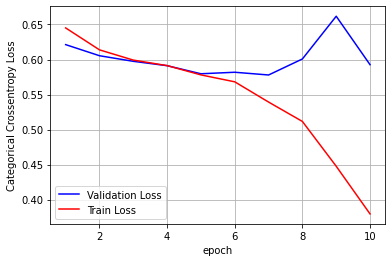

In [ ]:
#score = my_model.evaluate(X_test, y_test, verbose=0) 
#print('Test score:', score[0]) 
#print('Test accuracy:', score[1])
nb_epoch=10
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,nb_epoch+1))

vy = history_1.history['val_loss']
ty = history_1.history['loss']
plt_dynamic(x, vy, ty, ax)

In [ ]:
#import numpy as np
import time
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
#, colors=['b']
def plt_dynamic_auc(x, vy, ty, ax,colors=['b']):
    ax.plot(x, vy, 'b', label="Validation AUC")
    ax.plot(x, ty, 'r', label="Train AUC")
    plt.legend()
    plt.grid()
    fig.canvas.draw()
    #plt.show()

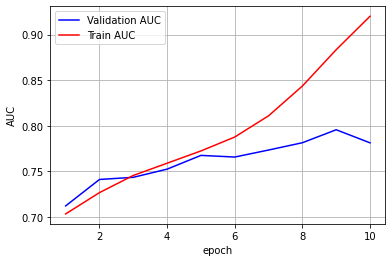

In [ ]:
#score = my_model.evaluate(X_test, y_test, verbose=0) 
#print('Test score:', score[0]) 
#print('Test accuracy:', score[1])
nb_epoch=10
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('AUC')

# list of epoch numbers
x = list(range(1,nb_epoch+1))

vy = history_1.history['val_auc']
ty = history_1.history['auc']
plt_dynamic_auc(x, vy, ty, ax)

In [ ]:
from sklearn.metrics import roc_curve, auc
probs1 = my_model.predict(X_test)
probs = probs1[:, 1]
fpr1, tpr1, thresholds1 = roc_curve(y_test1, probs)
roc_auc = auc(fpr1, tpr1)

In [ ]:
roc_auc

0.769384744558548

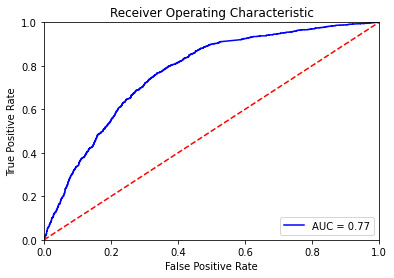

In [ ]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr1, tpr1, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# method II: ggplot
#from ggplot import *
##df = pd.DataFrame(dict(fpr = fpr, tpr = tpr))
#ggplot(df, aes(x = 'fpr', y = 'tpr')) + geom_line() + geom_abline(linetype = 'dashed')

In [ ]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    labels = [1,2]
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


-------------------- Confusion matrix --------------------


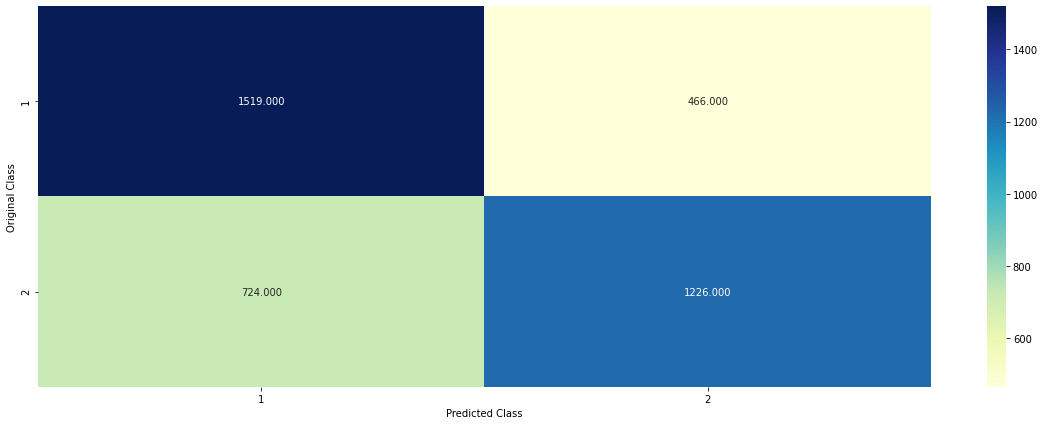

-------------------- Precision matrix (Columm Sum=1) --------------------


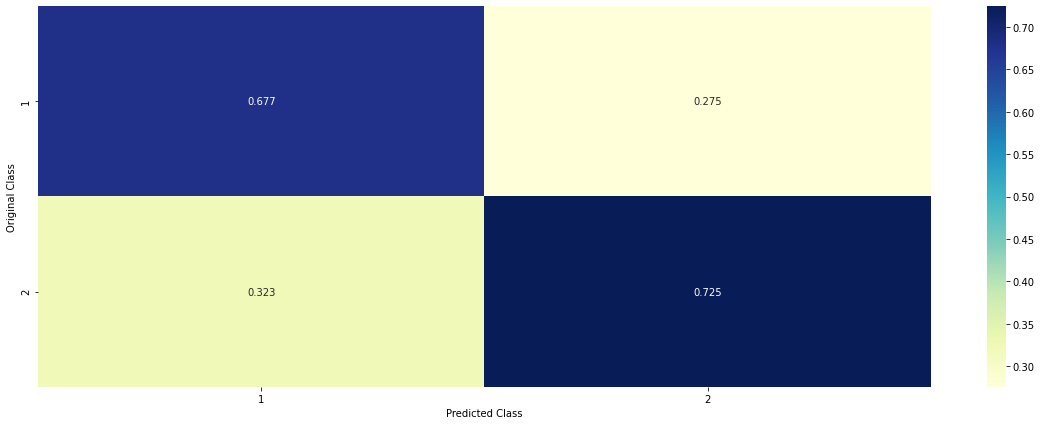

-------------------- Recall matrix (Row sum=1) --------------------


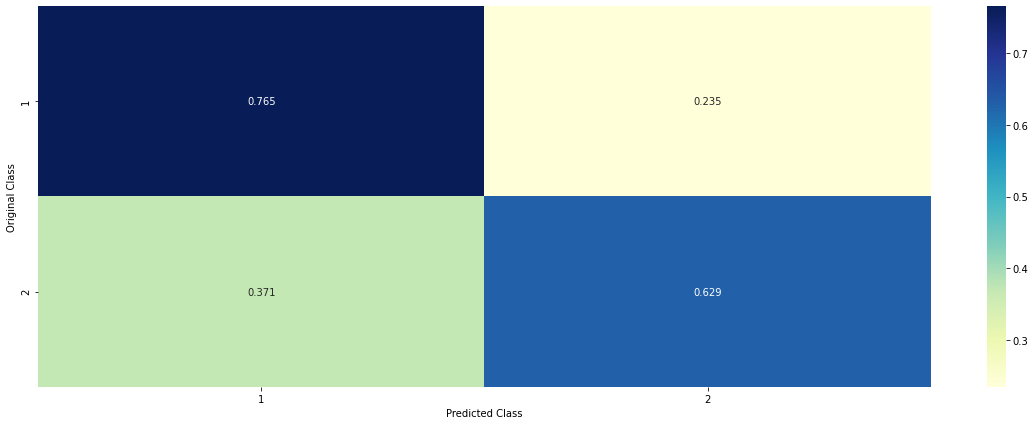

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
plot_confusion_matrix(y_test1,y_pred_class)